In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Load the Porto training dataset
data = pd.read_csv('creditcard.csv')

# Success
print "This dataset has {} data points with {} variables each.".format(*data.shape)

#y will hold the labels
y=data['Class']

#drop time class
X=data.drop(['Class','Time'],axis = 1) 

# use this to hold the amounts to evaluate error cost
amount=data['Amount']

print type(X)
print X.shape
print y.shape

data.info() #identify if there are any null values
data.keys() #identify the columns

This dataset has 284807 data points with 31 variables each.
<class 'pandas.core.frame.DataFrame'>
(284807, 29)
(284807,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non

Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')

In [38]:
#find % of transactions that are fraud by number
percent_fraud = 100*float(np.sum(y))/len(X)
print "{0:0.4f} % of the dataset are fraudulent transactions".format(percent_fraud)

#...and by value
total_value = np.sum(amount)
print "Total Value of Transactions = {:.2f}".format(total_value)
amount_fraud = np.sum(amount.loc[(y==1)])
print "Total Value of Fraud Transactions = {:.2f}".format(amount_fraud)
print "{0:0.4f} % is the % by value of fraudulent transactions".format\
(100*float(amount_fraud/total_value))

0.1727 % of the dataset are fraudulent transactions
Total Value of Transactions = 25162590.01
Total Value of Fraud Transactions = 60127.97
0.2390 % is the % by value of fraudulent transactions


##Visualization and Exploration

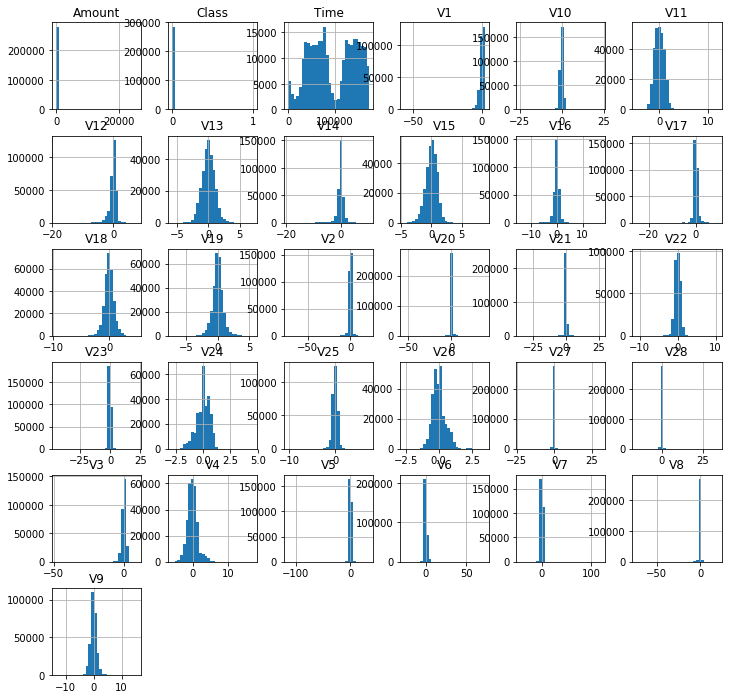

In [11]:
%matplotlib inline
hist = data.hist(bins=30,figsize=(12,12))

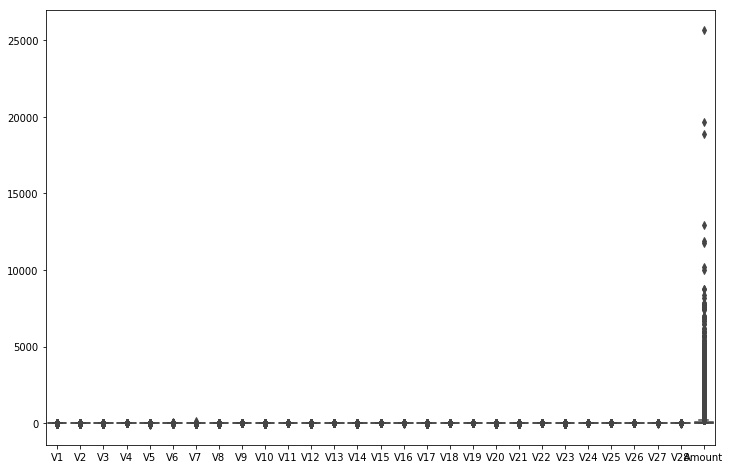

In [274]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,8))
data_df= data.drop(['Class','Time'],axis = 1)
sns.boxplot(data= data_df)

In [275]:
data['Hour']= data['Time'].apply(lambda x: np.ceil(float(x)/3600.) % 24)

/Applications/anaconda3/lib/python2.7/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


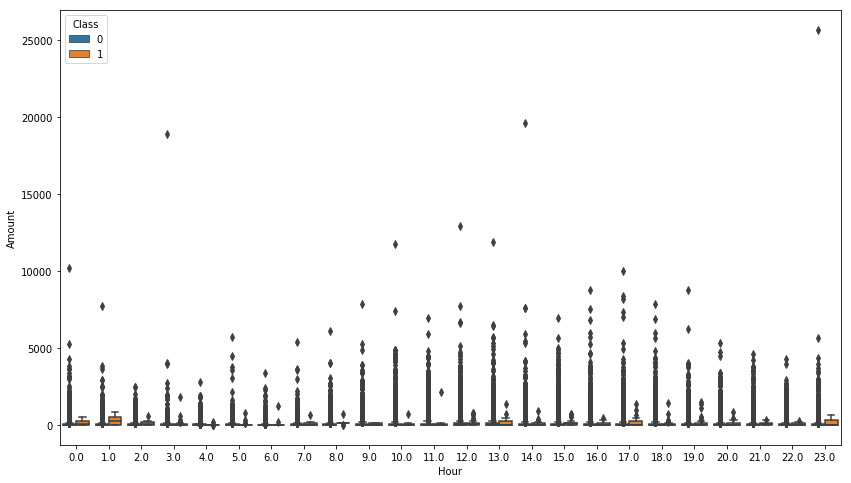

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,8))
sns.boxplot(x='Hour', y='Amount', data=data,hue='Class')

/Applications/anaconda3/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


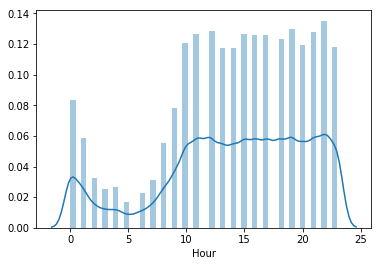

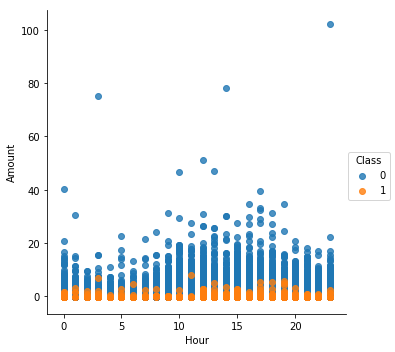

In [270]:
sns.distplot(data.Hour)
sns.lmplot(x='Hour', y='Amount', data=data,fit_reg=False,hue='Class')

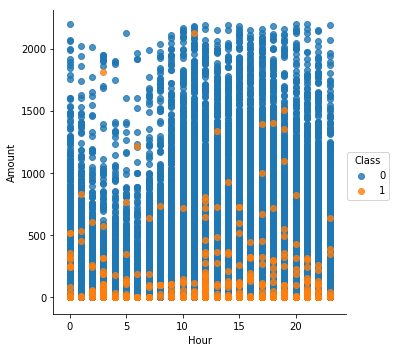

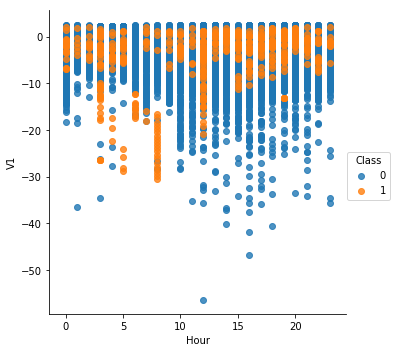

In [277]:
amount_class_df=data[['Amount','Hour','Class']].loc[data['Amount']<2200.]
sns.lmplot(x='Hour', y='Amount', data=amount_class_df,fit_reg=False,hue='Class')
sns.lmplot(x='Hour', y='V1', data=data,fit_reg=False,hue='Class')

In [62]:
# find highest value of amounts tagged as fraud
high_fraud_amounts = data.loc[data['Class']==1].sort_values(by=['Amount'],ascending=False)
high_fraud_amounts = high_fraud_amounts['Amount']
display(high_fraud_amounts.head())

176049    2125.87
6971      1809.68
249167    1504.93
89190     1402.16
81609     1389.56
Name: Amount, dtype: float64

There is no fraud for amounts greater than $ 2,126.

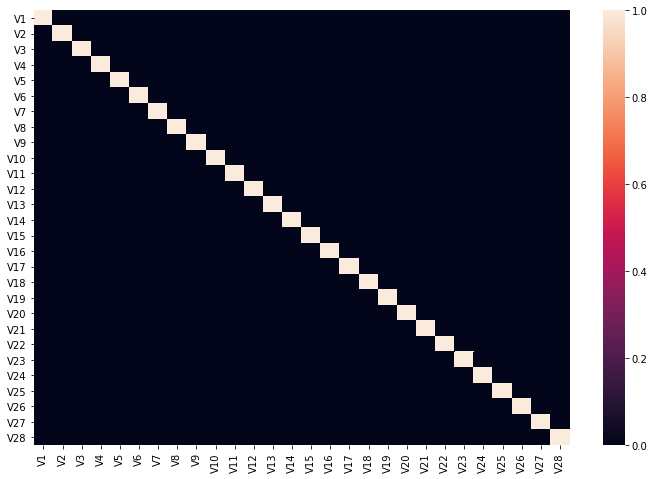

In [13]:
import seaborn as sns
plt.figure(figsize=(12,8))
data_df= data.drop(['Class','Time','Hour','Amount'],axis = 1)
sns.heatmap(data_df.corr())

The above indicates virtually no correlation between the features. Before we evaluate various classifiers, we define helper functions to draw performance curves and provide classifier metrics to be used for evaluation.

In [279]:
#Preprocess data to normalize the Amount feature
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])
#y will hold the labels
y=data['Class']
#drop time class since the fraud transactions are not connected
X=data.drop(['Class','Time'],axis = 1)
print X.shape
print y.shape

(284807, 30)
(284807,)


In [18]:
# Report the prediction scores and plot precision recall curve for various classifiers
from sklearn.metrics import precision_score,recall_score,precision_recall_curve, \
average_precision_score,fbeta_score,roc_curve,auc,classification_report,confusion_matrix

from sklearn.model_selection import train_test_split,StratifiedKFold
from scipy import interp
import itertools
import matplotlib.pyplot as plt


def draw_performance_curves(clf_name,classifier,X,y,sample_weight,n_folds=6):
    
    #note that sample weights are the transaction amounts
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)

    ## Initialize vars for ROC Curve
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
 
    cv = StratifiedKFold(n_splits=n_folds)
    for i,(train, test) in enumerate(cv.split(X,y)):
        if isinstance(X, pd.DataFrame):
            X=pd.DataFrame.as_matrix(X)
        classifier.fit(X[train], y[train],sample_weight=np.array(sample_weight[train]))
        probas_ = classifier.predict_proba(X[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1], pos_label=1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.4f)' % (i, roc_auc))
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    mean_tpr /= n_folds
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.4f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(clf_name + ' Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    
    ##Code for Precision Recall Curve
    plt.figure(figsize=(15,10))
    plt.subplot(2,1,2)

    mean_prec_score=0.
    mean_rec_score=0.    
    cv=StratifiedKFold(n_splits=n_folds)
    total_fn_loss =0.
    total_fp_loss=0.
    mean_total_fn_loss = 0.
    mean_total_fp_loss = 0.
    
    for i,(train,test) in enumerate(cv.split(X,y)):
        classifier.fit(X[train],y[train],sample_weight=np.array(sample_weight[train]))
        y_probas_ = classifier.predict_proba(X[test])
        y_pred=classifier.predict(X[test])
        precision, recall, thresholds = precision_recall_curve\
        (y[test], y_probas_[:, 1],pos_label=1)
        prec_score=precision_score(y[test], y_pred)
        rec_score=recall_score(y[test],y_pred)
        plt.plot(recall, precision, lw=1, \
                 label="PR fold {fold:1d} AP = {ap:0.4f} Recall = {rs:0.4f}".
                 format(fold=i,ap=prec_score,rs=rec_score)) 
        mean_prec_score+=prec_score
        mean_rec_score+=rec_score
   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.0, 1.0])

    mean_prec_score/=n_folds
    mean_rec_score/=n_folds

    title = clf_name + \
    (' Prec-Rec Mean Precision= {mean_p:0.3f} Mean Recall = {mean_rec_s:0.3f}').\
    format(mean_p=mean_prec_score,mean_rec_s=mean_rec_score)
    
    plt.legend(loc="lower right")
    plt.title(title)
    plt.show()

    
def feature_importance_graph(trained_clf):
    importances = trained_clf.get_fscore()
    importance_frame = pd.DataFrame({'Importance': list(importances.values()), \
                                     'Feature': list(importances.keys())})
    importance_frame.sort_values(by = 'Importance', inplace = True)
    importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (10,10), color = 'orange')
    
def output_classifier_score(clf_name,y_test,y_pred,y_pred_proba,amount):
    
    print clf_name
    average_precision = average_precision_score(y_test, y_pred_proba[:, 1], average='weighted')
    print "Average Precision = {0:0.4f}".format(average_precision)

    target_names=['Legit','Fraud']
    print classification_report(y_test, y_pred, target_names=target_names,digits=4)

    #plot confusion matrix
    plt.figure(figsize=(10,6))

    cm=confusion_matrix(y_test,y_pred)

    #Cost of False Negative
    total_fn_loss= np.sum(amount[(y_test == 1) & (y_pred == 0)]) 
    #Cost of False Positive
    total_fp_loss=0.5 * np.sum(amount[(y_test == 0) & (y_pred == 1)])


    print "Total_fn_loss = $ {:0.2f}".format(total_fn_loss)
    print "Total_fp_loss = $ {:0.2f}".format(total_fp_loss)
    print "Total cost of error = $ {:0.2f}".format(total_fn_loss + total_fp_loss)
    
    #cmap=plt.cm.Blues
    cmap = 'coolwarm_r'
    classes = ['Legit','Fraud']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", rotation = 'horizontal',
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Random Forest
Average Precision = 0.8373
             precision    recall  f1-score   support

      Legit     0.9996    1.0000    0.9998     56864
      Fraud     0.9733    0.7449    0.8439        98

avg / total     0.9995    0.9995    0.9995     56962

Total_fn_loss = $ 6536.21
Total_fp_loss = $ 123.41
Total cost of error = $ 6659.62


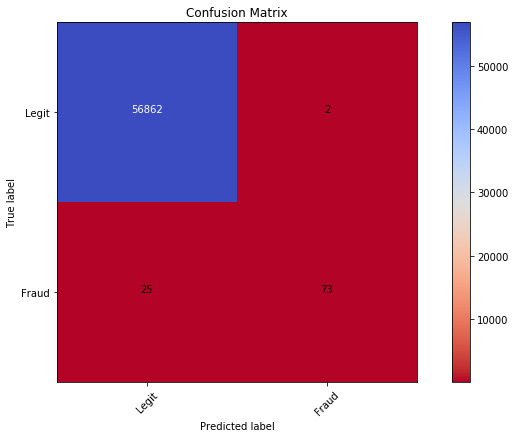

CPU times: user 21.8 s, sys: 191 ms, total: 22 s
Wall time: 22.1 s


In [8]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rand_clf = RandomForestClassifier(random_state=42)

X_train,X_test,y_train,y_test,amount_train,amount_test = \
train_test_split(X,y,amount,test_size=0.2,random_state=42)

classifiers= { 'Random Forest':rand_clf}

for clf_name,clf in classifiers.items():
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    y_pred_proba=clf.predict_proba(X_test)
    output_classifier_score(clf_name,y_test,y_pred,y_pred_proba,amount_test)

We will first look at ROC and precision recall curves for basic classifiers to determine which performs best.

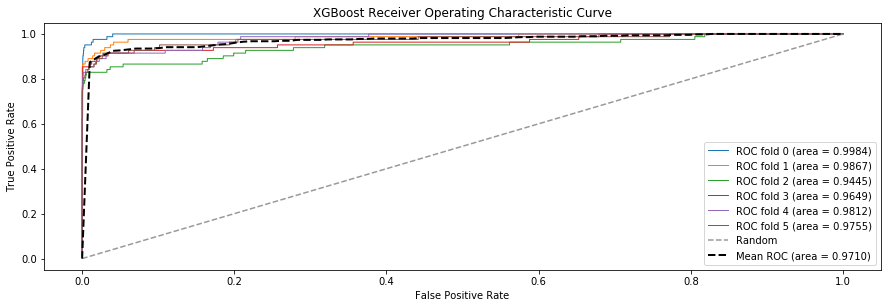

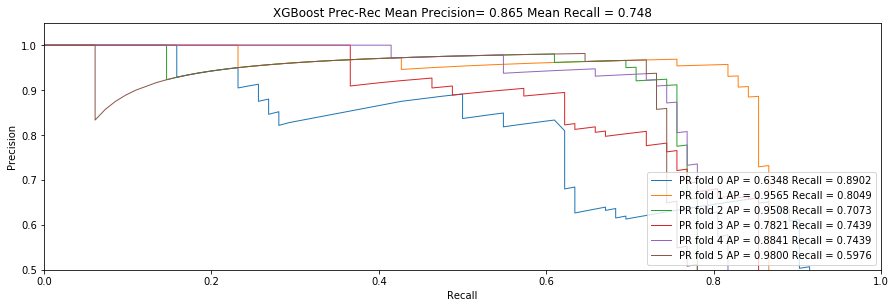

--- Execution Time for XGBoost is 1936.28259611 seconds ---


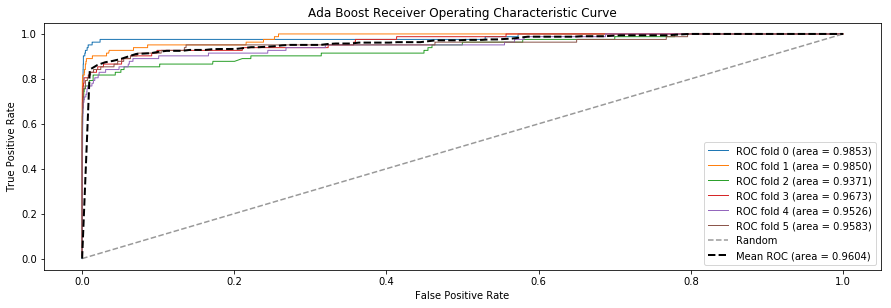

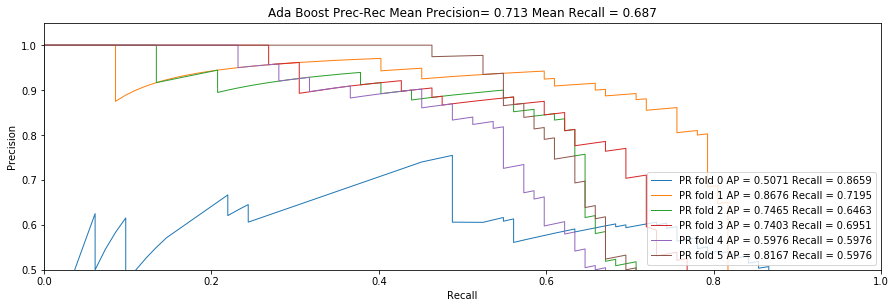

--- Execution Time for Ada Boost is 864.777837992 seconds ---


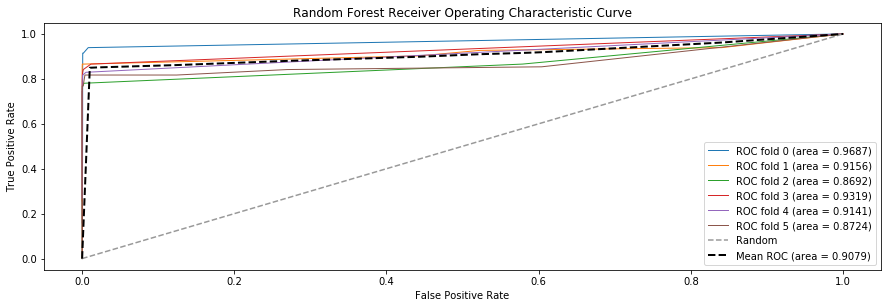

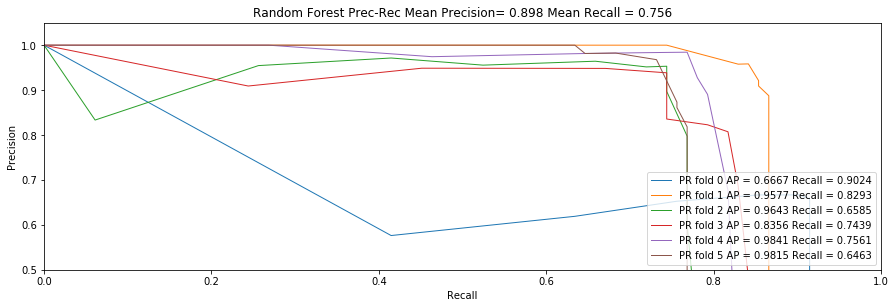

--- Execution Time for Random Forest is 271.443953037 seconds ---


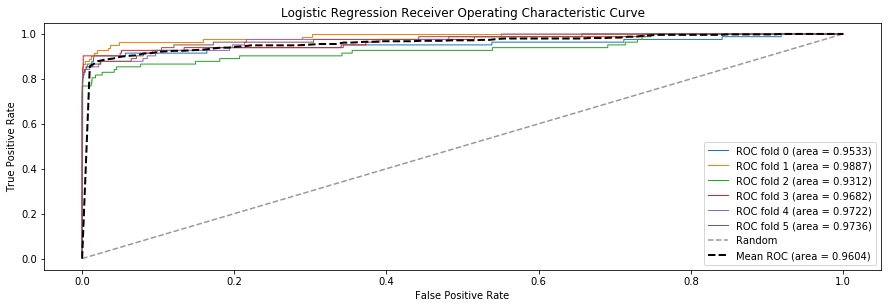

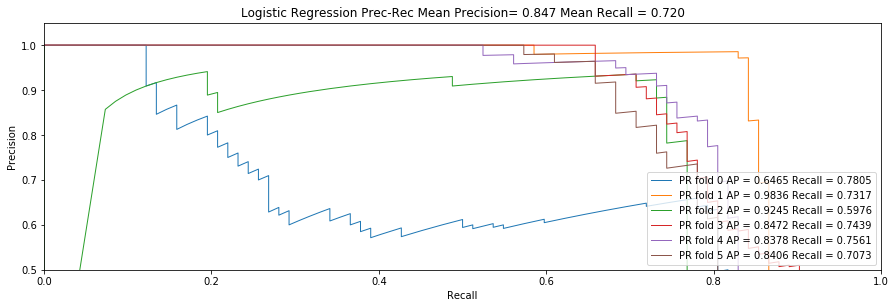

--- Execution Time for Logistic Regression is 107.626726866 seconds ---


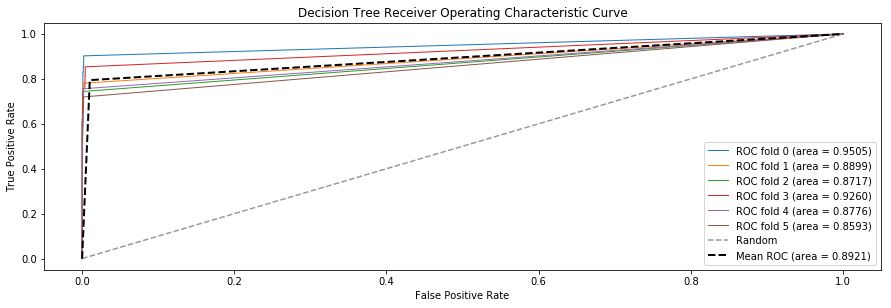

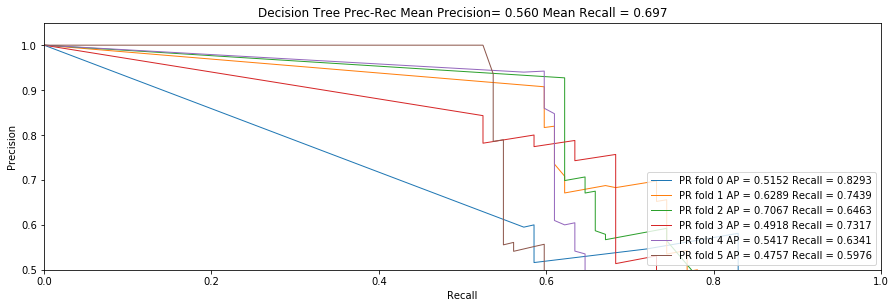

--- Execution Time for Decision Tree is 298.449856997 seconds ---


In [181]:
import time

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
rand_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

from sklearn.tree import DecisionTreeClassifier
# min_samples_leaf =5 to avoid overfitting
dectree_clf = DecisionTreeClassifier(min_samples_leaf=5,random_state=42) 

from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression()

import xgboost as xgb
xgboost_clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

classifiers= {'Logistic Regression': logistic_clf,'Decision Tree':dectree_clf, 
              'Random Forest':rand_clf,
              'Ada Boost':ada_clf,
            'XGBoost':xgboost_clf}

for clf_name,clf in classifiers.items():
    start_time = time.time()
    draw_performance_curves(clf_name,clf,X,y,amount)
    print("--- Execution Time for {} is {} seconds ---")\
    .format(clf_name,(time.time() - start_time))

XGBoost
Average Precision = 0.8754
             precision    recall  f1-score   support

      Legit     0.9997    0.9999    0.9998     56864
      Fraud     0.9639    0.8163    0.8840        98

avg / total     0.9996    0.9996    0.9996     56962

Total_fn_loss = $ 3738.36
Total_fp_loss = $ 634.63
Total cost of error = $ 4372.99


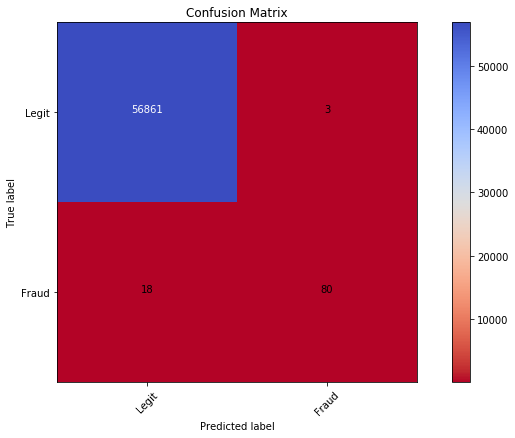

Ada Boost
Average Precision = 0.7840
             precision    recall  f1-score   support

      Legit     0.9995    0.9998    0.9996     56864
      Fraud     0.8372    0.7347    0.7826        98

avg / total     0.9993    0.9993    0.9993     56962

Total_fn_loss = $ 3256.93
Total_fp_loss = $ 1204.05
Total cost of error = $ 4460.99


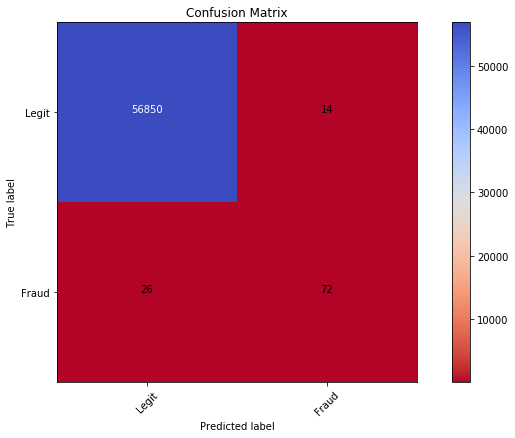

Random Forest
Average Precision = 0.8373
             precision    recall  f1-score   support

      Legit     0.9996    1.0000    0.9998     56864
      Fraud     0.9733    0.7449    0.8439        98

avg / total     0.9995    0.9995    0.9995     56962

Total_fn_loss = $ 6536.21
Total_fp_loss = $ 123.41
Total cost of error = $ 6659.62


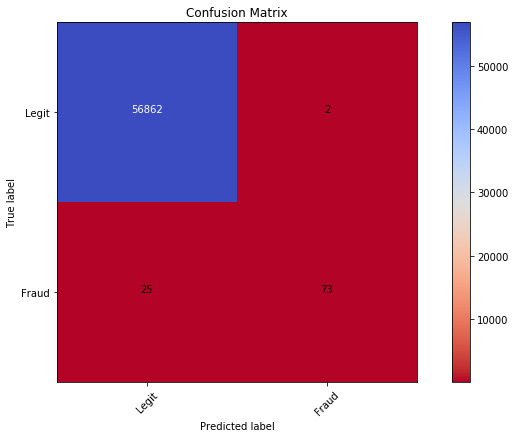

Logistic Regression
Average Precision = 0.7621
             precision    recall  f1-score   support

      Legit     0.9993    0.9998    0.9996     56864
      Fraud     0.8615    0.5714    0.6871        98

avg / total     0.9990    0.9991    0.9990     56962

Total_fn_loss = $ 8420.42
Total_fp_loss = $ 481.59
Total cost of error = $ 8902.01


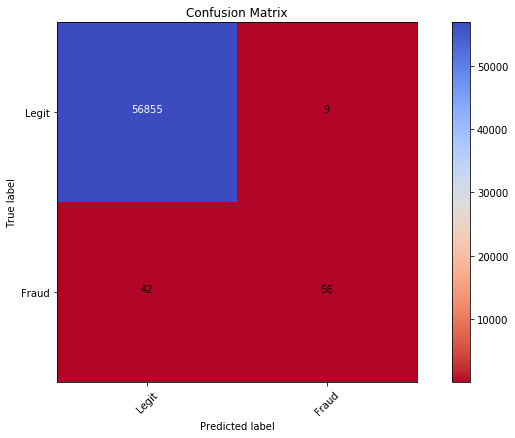

Decision Tree
Average Precision = 0.8071
             precision    recall  f1-score   support

      Legit     0.9996    0.9998    0.9997     56864
      Fraud     0.8750    0.7857    0.8280        98

avg / total     0.9994    0.9994    0.9994     56962

Total_fn_loss = $ 4658.37
Total_fp_loss = $ 995.00
Total cost of error = $ 5653.36


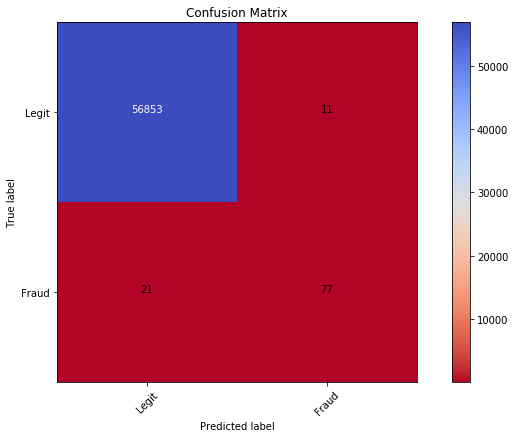

CPU times: user 4min 10s, sys: 2.46 s, total: 4min 12s
Wall time: 4min 14s


In [9]:
%%time
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import train_test_split

rand_clf = RandomForestClassifier(random_state=42)
ada_clf = AdaBoostClassifier(random_state=42)

from sklearn.tree import DecisionTreeClassifier
# min_samples_leaf to avoid overfitting
dectree_clf = DecisionTreeClassifier(min_samples_leaf=5,random_state=42) 

from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression()

import xgboost as xgb
xgboost_clf = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05)

X_train,X_test,y_train,y_test,amount_train,amount_test = \
train_test_split(X,y,amount,test_size=0.2,random_state=42)

classifiers= {'Logistic Regression': logistic_clf,'Decision Tree':dectree_clf, 
              'Random Forest':rand_clf,
              'Ada Boost':ada_clf,
            'XGBoost':xgboost_clf}

for clf_name,clf in classifiers.items():
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    y_pred_proba=clf.predict_proba(X_test)
    output_classifier_score(clf_name,y_test,y_pred,y_pred_proba,amount_test)

In [94]:
import pickle
#save model for basic xgboost without parameter tuning
pickle.dump(xgboost_clf, open("xgboost_basic.pickle.dat", "wb"))
print xgboost_clf.get_xgb_params()

{'reg_alpha': 0, 'colsample_bytree': 1, 'silent': 1, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.05, 'missing': nan, 'max_delta_step': 0, 'nthread': 1, 'base_score': 0.5, 'n_estimators': 300, 'subsample': 1, 'reg_lambda': 1, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 0, 'max_depth': 3, 'gamma': 0, 'booster': 'gbtree'}


Since XGBoost performs the best of all the classifiers, we will use this for further exploration. At this point, there are two approaches. The first is to tune hyper-parameters of XGBoost. The second approach is to explore data-based methods to improve the balance of the underlying dataset and see if that performs better. We will try the first one and depending on results obtained, look to implement sampling methods.

In [210]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'max_depth': [3,5,7], 'min_child_weight': [1,3,5]}
ind_params = {'learning_rate': 0.1, 'n_estimators': 300, 'random_state':0, 
              'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter=8)
optimized_GBM.fit(X_train, y_train)

CPU times: user 1h 14min 39s, sys: 35.2 s, total: 1h 15min 14s
Wall time: 1h 25min 10s


In [211]:
optimized_GBM.cv_results_

{'mean_fit_time': array([  86.39835863,  127.03863144,  101.57327456,  165.04504542,
         150.19488902,   98.77531776,  151.89999576,   89.21975846]),
 'mean_score_time': array([ 0.42438059,  0.65006561,  0.49091301,  0.5348598 ,  0.54834399,
         0.4189496 ,  0.66673861,  0.4470365 ]),
 'mean_test_score': array([ 0.9783493 ,  0.97760498,  0.97807194,  0.9795661 ,  0.97622205,
         0.97890954,  0.97829799,  0.97863374]),
 'mean_train_score': array([ 0.99999911,  1.        ,  0.99999737,  1.        ,  1.        ,
         0.99999088,  1.        ,  0.99996257]),
 'param_max_depth': masked_array(data = [3 5 5 5 7 3 7 3],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_min_child_weight': masked_array(data = [1 1 5 3 3 3 1 5],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': [{'max_depth': 3, 'min_child_weight': 1},
  {'max_depth': 5, 'min_child_weight': 1},
  {'ma

In [212]:
import pickle
#save model for trained xgboost
pickle.dump(xgboost_clf, open("xgboost_trained.pickle.dat", "wb"))
print xgboost_clf.get_xgb_params()

{'reg_alpha': 0, 'colsample_bytree': 1, 'silent': 1, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.05, 'missing': None, 'max_delta_step': 0, 'nthread': 1, 'base_score': 0.5, 'n_estimators': 300, 'subsample': 1, 'reg_lambda': 1, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 0, 'max_depth': 3, 'gamma': 0, 'booster': 'gbtree'}


In [28]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split,RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cv_params = {'learning_rate': [0.2, 0.1, 0.01], 'subsample': [0.7,0.8,0.9]}
ind_params = {'n_estimators': 400, 'random_state':0, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth': 3, 'min_child_weight': 1}

optimized_GBM = RandomizedSearchCV(xgb.XGBClassifier(**ind_params), 
                            cv_params, 
                             scoring = 'roc_auc', cv = 5, n_jobs = 1, n_iter = 8)
optimized_GBM.fit(X_train, y_train)

CPU times: user 1h 15min 30s, sys: 40.8 s, total: 1h 16min 11s
Wall time: 1h 17min 25s


In [29]:
optimized_GBM.cv_results_

{'mean_fit_time': array([ 104.4061234 ,  111.78930502,  106.290589  ,  111.64697495,
         108.36609364,  108.78142252,  114.83848438,  110.8271492 ]),
 'mean_score_time': array([ 0.59728584,  0.59481158,  0.57724843,  0.57289166,  0.42356095,
         0.56339741,  0.41825581,  0.40638046]),
 'mean_test_score': array([ 0.97533936,  0.97868338,  0.97581373,  0.97924625,  0.95750518,
         0.97771192,  0.96142721,  0.95208869]),
 'mean_train_score': array([ 1.        ,  1.        ,  1.        ,  1.        ,  0.97254323,
         1.        ,  0.97150987,  0.97188597]),
 'param_learning_rate': masked_array(data = [0.2 0.1 0.2 0.1 0.01 0.1 0.01 0.01],
              mask = [False False False False False False False False],
        fill_value = ?),
 'param_subsample': masked_array(data = [0.7 0.7 0.8 0.8 0.8 0.9 0.7 0.9],
              mask = [False False False False False False False False],
        fill_value = ?),
 'params': [{'learning_rate': 0.2, 'subsample': 0.7},
  {'learning_rat

In [12]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

X_train, X_test, y_train, y_test,amount_train,amount_test = \
train_test_split(X, y, amount,test_size=0.25, random_state=42)
xgdmat = xgb.DMatrix(X_train, y_train)

In [13]:
%%time
#set our_params to use the parameters found by cv

our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.7, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':3} 

# Use xgb cv to find optimized settings

cv_xgb = xgb.cv(params = our_params, dtrain = xgdmat, num_boost_round = 3000, nfold = 5,
                metrics = ['auc'],
                early_stopping_rounds = 100) 
# Look for early stopping that minimizes error

CPU times: user 9min 48s, sys: 4.27 s, total: 9min 52s
Wall time: 3min 4s


In [33]:
cv_xgb.tail(10)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
114,0.979502,0.009407,0.999553,0.000114
115,0.979580,0.009653,0.999576,0.000119
116,0.979779,0.009119,0.999609,0.000116
117,0.979906,0.008913,0.999624,0.000120
118,0.979634,0.009318,0.999652,0.000101
119,0.979459,0.009361,0.999657,0.000095
120,0.979371,0.009414,0.999666,0.000092
121,0.979821,0.009319,0.999676,0.000087
122,0.979926,0.008866,0.999681,0.000082
123,0.979973,0.008758,0.999692,0.000081


In [37]:
%%time
our_params = {'eta': 0.1, 'seed':0, 'subsample': 0.7, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic', 'max_depth':5, 'min_child_weight':3} 

final_gb = xgb.train(our_params, xgdmat, num_boost_round = 123)


CPU times: user 1min 1s, sys: 222 ms, total: 1min 2s
Wall time: 1min 1s


Tuned XG Boost
Average Precision = 0.8863
             precision    recall  f1-score   support

      Legit     0.9997    1.0000    0.9998     71089
      Fraud     0.9681    0.8053    0.8792       113

avg / total     0.9996    0.9996    0.9996     71202

Total_fn_loss = $ 4023.69
Total_fp_loss = $ 60.99
Total cost of error = $ 4084.68


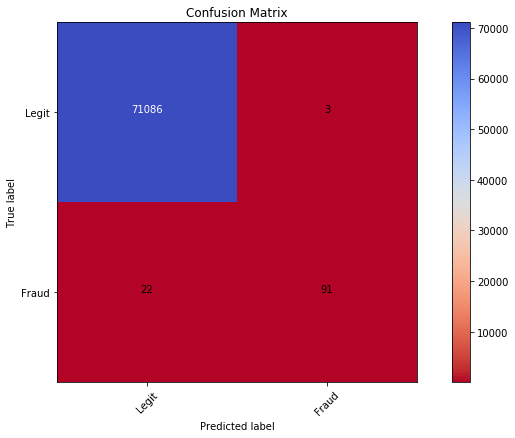

In [38]:
testdmat = xgb.DMatrix(X_test)
y_pred_proba = final_gb.predict(testdmat) #this only outputs probabilities
y_pred=np.empty_like(y_test) #initialize predictions
y_pred[y_pred_proba > 0.5] = 1
y_pred[y_pred_proba <= 0.5] = 0

#stack the prediction along with the probabilities
y_pred_proba = np.stack((y_pred,y_pred_proba),axis=-1)
output_classifier_score('Tuned XG Boost',y_test,y_pred,y_pred_proba,amount_test)

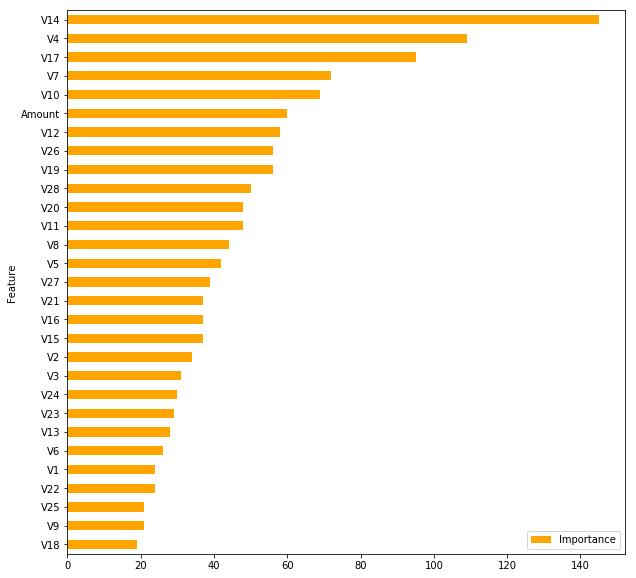

In [30]:
feature_importance_graph(final_gb)

In [35]:
final_gb.save_model('xgboost_final_tuned.model')

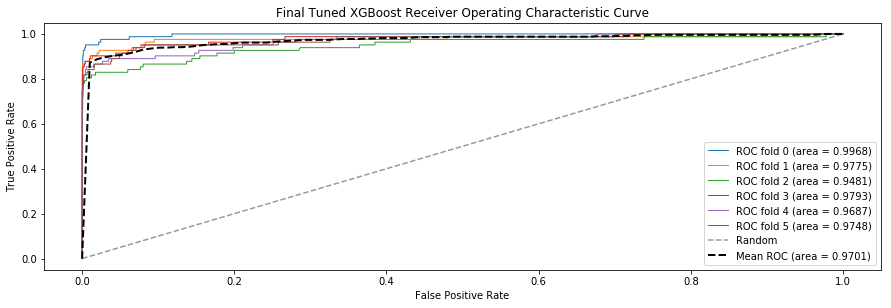

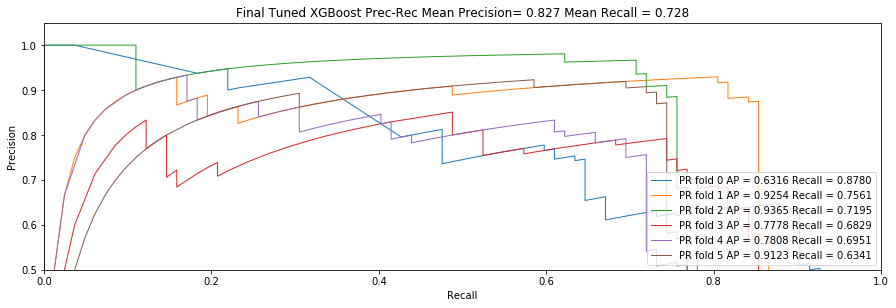

--- Execution Time for Final Tuned XGBoost is 623.899185181 seconds ---


In [39]:
# now that we have found the right set of hyper parameters, we use 
# cross-validation to determine how robust our model is
import time
start_time = time.time()
clf_name= 'Final Tuned XGBoost'
xgb_clf=xgb.XGBClassifier()
xgb_clf._Booster=final_gb
draw_performance_curves(clf_name,xgb_clf,X,y,amount)
print("--- Execution Time for {} is {} seconds ---")\
    .format(clf_name,(time.time() - start_time))

,DataSet,AUPRC,Recall
0,Test Data Set,0.8863,0.9996
1,Fold 0,0.6316,0.8780
2,Fold 1,0.9254,0.7561
3,Fold 2,0.9365,0.7195
4,Fold 3,0.7778,0.6829
5,Fold 4,0.7808,0.6909
6,Fold 5,0.9123,0.6341


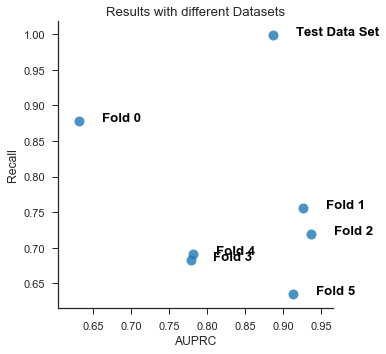

In [54]:
result_df = pd.DataFrame({'DataSet' : ['Test Data Set', 'Fold 0', 'Fold 1', 'Fold 2',
                                  'Fold 3', 'Fold 4', 'Fold 5'],
                   'AUPRC' : [0.8863,0.6316,0.9254,0.9365,0.7778,0.7808,0.9123],
                          'Recall': [0.9996,0.8780,0.7561,0.7195,0.6829,0.6909,0.6341]})
result_df = result_df[['DataSet', 'AUPRC', 'Recall']]
display(result_df)

# Set style of scatterplot
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

# Create scatterplot of dataframe
sns.lmplot('AUPRC', # Horizontal axis
           'Recall', # Vertical axis
           data=result_df, # Data source
           fit_reg=False, # Don't fix a regression line
           scatter_kws={"marker": "D", # Set marker style
                        "s": 100}) # S marker size

# Set title
plt.title('Results with different Datasets')

# Set x-axis label
plt.xlabel('AUPRC')

# Set y-axis label
plt.ylabel('Recall')

for line in range(0,result_df.shape[0]):
     plt.gca().text(result_df.AUPRC[line]+0.03, result_df.Recall[line], \
             result_df.DataSet[line], horizontalalignment='left', \
             size='medium', color='black', weight='semibold')

In [100]:
# Explore data-based methods
from imblearn.over_sampling import RandomOverSampler
OverSampler=RandomOverSampler(random_state=42)
X_over,y_over = OverSampler.fit_sample(X, y)

from imblearn.under_sampling import RandomUnderSampler,NearMiss
UnderSampler=RandomUnderSampler(random_state=42)
X_under,y_under = UnderSampler.fit_sample(X, y)

NearMissSampler=NearMiss(random_state=42)
X_nearmiss,y_nearmiss = NearMissSampler.fit_sample(X, y)

from imblearn.combine import SMOTEENN
SMOTESampler=SMOTEENN(random_state=42)
X_smote,y_smote = SMOTESampler.fit_sample(X, y)

In [ ]:
#helper function to evaluate sampler
def evaluate_sampler(clf_name,y_test,y_pred,amount):    

    print clf_name
    print "-------------"
    print "Precision Score = {:0.4f}".format(precision_score (y_test,y_pred))
    print "Recall Score = {:0.4f}".format(recall_score (y_test,y_pred))
    print "F Beta Score = {:0.4f}".format(fbeta_score (y_test,y_pred, beta = 1.0))
    
    #Cost of False Negative
    total_fn_loss= np.sum(amount[np.where((y_test == 1) & (y_pred == 0))]) 
    #Cost of False Positive
    total_fp_loss=0.5 * np.sum(amount[np.where((y_test == 0) & (y_pred == 1))])
    
    print "Total_fn_loss = $ {:0.2f}".format(total_fn_loss)
    print "Total_fp_loss = $ {:0.2f}".format(total_fp_loss)
    print "Total cost of error = $ {:0.2f}".format(total_fn_loss + total_fp_loss)

In [153]:
import pickle
from sklearn.model_selection import train_test_split


xgboost_clf = pickle.load(open("xgboost_basic.pickle.dat", "rb"))

for sampler_name,X,y in [('OverSampler',X_over,y_over),
                         ('UnderSampler',X_under,y_under),
                         ('NearMiss',X_nearmiss,y_nearmiss),
                        ('SMOTE ENN',X_smote,y_smote)]:
    X_train, X_test, y_train, y_test = \
    train_test_split(X,y, test_size=0.25, random_state=42)
    transaction_amount = X[:,28] # Amount is the 28th column
    xgboost_clf.fit(X_train,y_train)
    y_pred = xgboost_clf.predict(X_test)
    evaluate_sampler(sampler_name,y_test,y_pred,transaction_amount)

OverSampler
-------------
Precision Score = 0.9959
Recall Score = 1.0000
F Beta Score = 0.9967
Total_fn_loss = $ 0.00
Total_fp_loss = $ 15327.61
Total cost of error = $ 15327.61
UnderSampler
-------------
Precision Score = 0.9636
Recall Score = 0.8833
F Beta Score = 0.9464
Total_fn_loss = $ 784.90
Total_fp_loss = $ 521.72
Total cost of error = $ 1306.61
NearMiss
-------------
Precision Score = 1.0000
Recall Score = 0.9917
F Beta Score = 0.9983
Total_fn_loss = $ 0.76
Total_fp_loss = $ 0.00
Total cost of error = $ 0.76
SMOTE ENN
-------------
Precision Score = 0.9926
Recall Score = 0.9848
F Beta Score = 0.9911
Total_fn_loss = $ 84964.72
Total_fp_loss = $ 27396.14
Total cost of error = $ 112360.86


The above results show that the NearMiss re-sampling method yields excellent results with no 
false positive loss and significantly lower error cost.